In [60]:
import pandas as pd

import keras
from keras.layers import Input, Dense, Lambda, RNN, SimpleRNN
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist
from keras.layers.core import Reshape

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mpl_toolkits.axes_grid1 import ImageGrid

import matplotlib.gridspec as gridspec

In [3]:
train = pd.read_csv("kaggle_data/exoTrain.csv")
test = pd.read_csv("kaggle_data/exoTest.csv")

In [4]:
y_train = train.LABEL
x_train = train.drop('LABEL', axis=1)

y_test = test.LABEL
x_test = test.drop('LABEL', axis=1)

x_train = x_train.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)
x_test = x_test.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

In [5]:
batch_size = 100
original_dim = x_train.iloc[1].shape[0]
#original_dim = 784
epochs = 50
epsilon_std = 1.0
intermediate_dim = 256
latent_dim=2

In [16]:
class minRnnCell(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(minRnnCell, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                       initializer='uniform',
                                       name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True
        
    def call(self, inputs, states):
        prev_output = states[0]
        h = K.dot(inputs, self.kernel)
        output = h + K.dot(prev_output, self.recurrent_kernel)
        return output, [output]
    

In [92]:
rnn_cell = minRnnCell(32)

x = Input(shape=(original_dim,))
h = SimpleRNN(32)(x)
#h = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

ValueError: Input 0 is incompatible with layer simple_rnn_20: expected ndim=3, found ndim=2

In [45]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)*epsilon


In [79]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
z = Reshape((latent_dim,1))(z)

Tensor("reshape_10/Reshape:0", shape=(?, 2, 1), dtype=float32)


In [90]:
rnn_d_cell = minRnnCell(32)
decoder_h = SimpleRNN(32)

#decoder_h = Dense(intermediate_dim, activation='relu', name='potato')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
print(x_decoded_mean)
x_decoded_mean = Reshape((1,original_dim))(x_decoded_mean)
print(x_decoded_mean)

Tensor("dense_34/Sigmoid:0", shape=(?, 3197), dtype=float32)
Tensor("reshape_17/Reshape:0", shape=(?, 1, 3197), dtype=float32)


In [87]:
vae = Model(x, x_decoded_mean)

In [88]:
# Compute VAE loss
print(original_dim)
print(metrics.binary_crossentropy(x, x_decoded_mean))
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)


3197


ValueError: logits and labels must have the same shape ((?, 3197, 1) vs (?, ?, 3197))

In [11]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3197)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          818688      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

/home/dougwoodward/CADS/thesis/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Output "dense_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_4" during training.
  


In [12]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test,None))

Train on 5087 samples, validate on 570 samples
Epoch 1/50
5087/5087 [==============================] - 1s 169us/step - loss: 2174.7979 - val_loss: 2038.4679
Epoch 2/50
5087/5087 [==============================] - 0s 60us/step - loss: 2068.4889 - val_loss: 2017.0009
Epoch 3/50
5087/5087 [==============================] - 0s 62us/step - loss: 1978.0997 - val_loss: 1770.3242
Epoch 4/50
5087/5087 [==============================] - 0s 61us/step - loss: 1870.0884 - val_loss: 1725.6947
Epoch 5/50
5087/5087 [==============================] - 0s 61us/step - loss: 1837.1566 - val_loss: 1716.8147
Epoch 6/50
5087/5087 [==============================] - 0s 61us/step - loss: 1843.6329 - val_loss: 1719.8928
Epoch 7/50
5087/5087 [==============================] - 0s 62us/step - loss: 1860.5231 - val_loss: 1846.1482
Epoch 8/50
5087/5087 [==============================] - 0s 60us/step - loss: 1803.4919 - val_loss: 2173.2092
Epoch 9/50
5087/5087 [==============================] - 0s 60us/step - loss: 182

In [13]:
encoder = Model(x, z_mean)

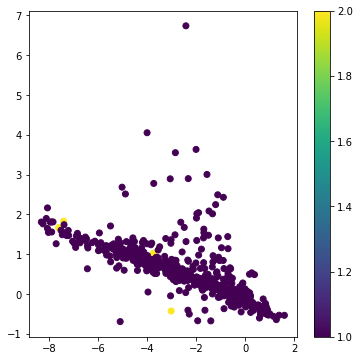

In [14]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test)
plt.colorbar()
plt.show()

In [15]:
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

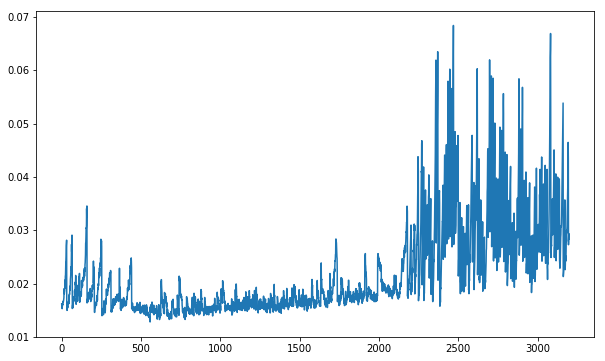

In [16]:
z_sample = np.array([[1,1]])
x_decoded = generator.predict(z_sample)
xx = np.linspace(0, original_dim, original_dim)
plt.figure(figsize=(10,6))
plt.plot(xx, x_decoded[0])

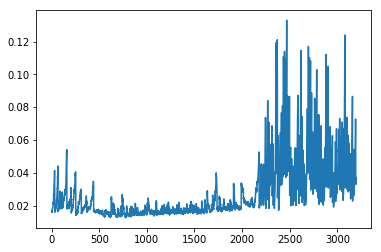

In [17]:
z_sample = np.array([[1, 2]])
x_decoded = generator.predict(z_sample)
xx = np.linspace(0, original_dim, original_dim)
plt.plot(xx, x_decoded[0])

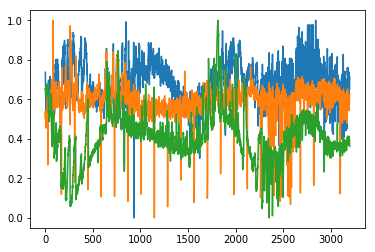

In [18]:
xx = np.linspace(0, original_dim, original_dim)
for i in range(3):    
    plt.plot(xx, x_train.iloc[i])


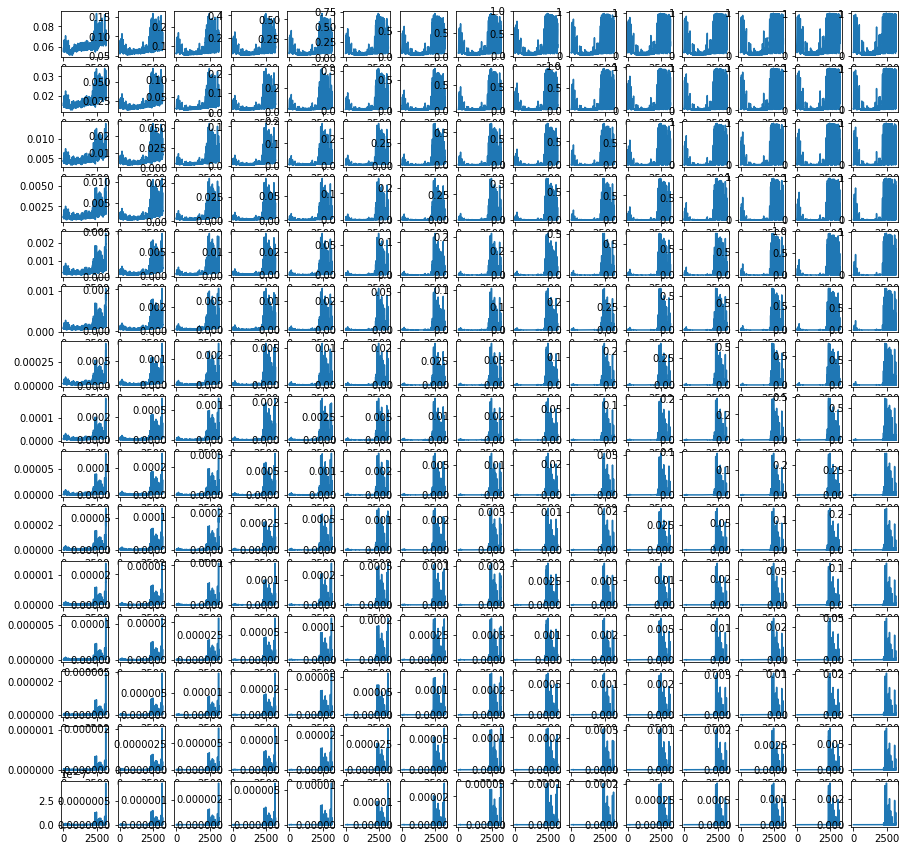

In [19]:
rows = 15
cols = 15

f, axarr = plt.subplots(rows, cols, figsize=(rows,cols))
for i in range(rows):
    for j in range(cols):
        z_sample = np.array([[i, j]])
        x_decoded = generator.predict(z_sample)
        xx = np.linspace(0, original_dim, original_dim)
        axarr[i,j].plot(xx, x_decoded[0])


Next:
 - build in an understanding of the time series nature of data
   ie: recurrent connections in model
   
 - are we normalizing correctly?
 
 - higher dimensional latent space and visualize with t-SNE
 
 - can we have it encode the PC/AFP/NTP models?
    specifically can we get it to encode the transit signature into the latent dim?
    

4/18: Meeting Agenda

- timeline for thesis work
   May 19 -> graduation
   When does draft need to be in by?
   think can get it done by graduation, at least for defense
   mayhaps could be expanded afterwards
 
- Here's the VAE for light curve generation -> good idea?

- Purpose:
    - acquiring light curves is expensives -> see TESS launch happening today
    - can only capture the light curves at certain angles to our view/certain area of sky
    - by generating them from a distribution produced from the VAE nd the latent space variables
    - hopefully, we can identify that some of these latent variables map to features in the real data
    - ie: we identify that zsub4 maps to the major sine fluctuation or the periodicity of the TCE
    - we also want to be able to map things to the class PC/NTP/AFP hopefully
    
 - Next Steps:
    - handle time series correlation
    - is this normalizing time series correctly?
       - i think this makes sense
    - handle injecting TCEs in some way - like need to able to produce some tces as well!
    - use actual light curve data ala astronet
       - first take a small sample of astonet data and test run on that first
       - long cadence v short cadence?
       - need to decide on a length of the time series
    

- Any desired length of paper?
- other thesis reqs?
- presentation?
- Defense format?
- Given what I'm proposing, should I augment/adjust any of this?